### Downloading the data

In [1]:
from main import main
key = '<replace with your key>' # this is the key for the weather data API

In [2]:
# uncomment this line at your own risk
# it will take ~15-20 minutes to download the data and to do some cleaning
# main(key)

In [3]:
from configs import merged_cycle_data_file
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

### Load the weather & holiday data

In [4]:
from configs import weather_data_csv

holidays = 'holidays.csv'
hol_df = pd.read_csv(holidays, index_col='date', parse_dates=['date'])
weather_df = pd.read_csv(weather_data_csv, index_col='timestamp', parse_dates=['timestamp'])
weather_df.head()

,temperature,feelsLike,wind,weatherCode
timestamp,,,,
2012-01-01 00:00:00,11,9,21,119
2012-01-01 01:00:00,11,9,22,119
2012-01-01 02:00:00,11,9,24,122
2012-01-01 03:00:00,11,8,26,122
2012-01-01 04:00:00,11,8,24,122


In [5]:
# get a set of the holiday dates
hol_set= set(hol_df.index.map(lambda x: x.date()))

### Load the merged csv file by reading it in chunks

# Warning:
The next cell takes a lot of time (it took 5h 10 mins for us) so uncomment this cell at your own risk.

In [6]:
# %%time
# from datetime import datetime
# import time

# chunk_size = 500000
# date_mapper = lambda x: pd.to_datetime(datetime(year=x.year, month=x.month, day=x.day, hour=x.hour))

# bike_share_df = pd.DataFrame()
# print('Started loading merged_cycle_data_file.')
# iter_ = pd.read_csv(merged_cycle_data_file, chunksize=chunk_size, iterator=True,
#         index_col='Rental Id',
#         parse_dates=['End Date', 'Start Date'])
# print('Finished loading merged_cycle_data_file.')

# r_start = time.time()
# for i, df in enumerate(iter_):
#     r_end = time.time()
#     print(f'{i+1}. Read rows {chunk_size*i}:{chunk_size*(i+1)} in {r_end-r_start:.3f}. ', end='')

#     start = time.time()
#     df = df.dropna()
#     # leave only entries that have valid duration
#     df = df[df['Duration'] > 0]
    
#     diff = df['End Date'] - df['Start Date'] # compute the difference between the objects
#     seconds = diff.map(lambda x: x.total_seconds()) # map to seconds
#     df = df[(df['Duration'] == seconds) & (seconds >= 0)] # check if duration matches the result and if the result is positive
    
    
#     # keep only year, month, day, hour information from the start date
#     df['Start Date'] = df['Start Date'].map(date_mapper)
#     # count the number of shares per hour
#     share_df = df.groupby('Start Date').agg({'Start Date': 'count'}).rename(columns={'Start Date': 'share_count'})
#     # join of weather data
#     share_df = share_df.join(weather_df)
#     # reset index
#     share_df = share_df.reset_index().rename(columns={'index': 'Start Date'})
#     share_df = share_df.dropna()
    
#     share_df['month'] = share_df['Start Date'].apply(lambda t: t.month)
#     share_df['weekday'] = share_df['Start Date'].apply(lambda t: t.weekday())
#     share_df['hour'] = share_df['Start Date'].apply(lambda t: t.hour)
#     share_df['is_holiday'] = share_df['Start Date'].map(lambda x: x.date() in hol_set).map(lambda x: '1' if x else '0')
#     # check if start date hits on a weekend
#     # monday is 0, sunday is 6
#     share_df['is_weekend'] = share_df['Start Date'].map(lambda x: x.weekday() > 4).map(lambda x: '1' if x else '0')
#     share_df['weatherCode'] = share_df['weatherCode'].map(lambda x: str(int(x)))
    
#     bike_share_df = bike_share_df.append(share_df)
#     end = time.time()
#     print(f'Completed cleaning & merging in {end-start:3.3f} seconds.')
#     r_start = time.time()

# print('Finished reading!')
# # bike_share_df = bike_share_df.reset_index(drop=True)
# # because of reading in chunks, some hours appear multiple times
# print('Grouping the hours')
# share_total = bike_share_df.groupby('Start Date').agg({'share_count': 'sum'})
# share_row = bike_share_df.groupby('Start Date').agg(lambda x: x.iloc[0])
# share_row['share_count'] = share_total['share_count']
# bike_share_df = share_row.reset_index()
# print('Saving to file')
# # save the data to a file, so that we can load it faster next time
# bike_share_df.sort_values('Start Date').reset_index(drop=True).to_csv('bike-shares.csv', index=False)

In [7]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str
}
bike_share_df = pd.read_csv('bike-shares.csv', parse_dates=['Start Date'], dtype=types)
fig_size = (18, 25)
random_state = 42069
test_size = 0.2

In [8]:
bike_share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64904 entries, 0 to 64903
Data columns (total 11 columns):
Start Date     64904 non-null datetime64[ns]
share_count    64904 non-null int64
temperature    64904 non-null float64
feelsLike      64904 non-null float64
wind           64904 non-null float64
weatherCode    64904 non-null object
month          64904 non-null int64
weekday        64904 non-null int64
hour           64904 non-null int64
is_holiday     64904 non-null object
is_weekend     64904 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 5.4+ MB


In [9]:
bike_share_df.head(6)

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,2012-01-02 00:00:00,35,7.0,4.0,19.0,116,1,0,0,1,0
1,2012-01-02 01:00:00,24,6.0,3.0,18.0,116,1,0,1,1,0
2,2012-01-02 02:00:00,21,6.0,3.0,17.0,113,1,0,2,1,0
3,2012-01-02 03:00:00,9,5.0,3.0,17.0,113,1,0,3,1,0
4,2012-01-02 04:00:00,12,5.0,2.0,18.0,113,1,0,4,1,0
5,2012-01-02 05:00:00,30,4.0,1.0,18.0,116,1,0,5,1,0


In [10]:
bike_share_df, test_set = train_test_split(bike_share_df, test_size=test_size, random_state=random_state)

In [11]:
bike_share_df = bike_share_df.sort_values('Start Date')

In [12]:
bike_share_df.describe()

,share_count,temperature,feelsLike,wind,month,weekday,hour
count,51923.000000,51923.000000,51923.000000,51923.000000,51923.000000,51923.000000,51923.000000
mean,1580.403135,11.058356,9.905090,14.818038,6.416501,2.993124,11.606379
std,1996.641946,6.177131,7.582529,7.410682,3.415149,1.999059,6.896880
min,1.000000,-9.000000,-11.000000,0.000000,1.000000,0.000000,0.000000
25%,113.000000,7.000000,4.000000,10.000000,3.000000,1.000000,6.000000
50%,777.000000,11.000000,10.000000,14.000000,6.000000,3.000000,12.000000
75%,2332.000000,15.000000,16.000000,19.000000,9.000000,5.000000,18.000000
max,15594.000000,35.000000,38.000000,65.000000,12.000000,6.000000,23.000000


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import numpy as np
# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
weather_ix, hour_ix, month_ix, share_ix = [
    list(bike_share_df.columns).index(col)
    for col in ('weatherCode', 'hour', 'month', 'share_count')]

cat_attribs = ['weatherCode', 'is_holiday', 'is_weekend']
num_attribs = list(bike_share_df.drop(cat_attribs, axis=1))

# num_pipeline = Pipeline([
#     ('selector', DataFrameSelector(num_attribs)),
#     ('imputer', Imputer(strategy="median")),
#     ('attribs_adder', CombinedAttributesAdder()),
#     ('std_scaler', StandardScaler()),
# ])


# cat_pipeline = Pipeline([
#     ('selector', DataFrameSelector(cat_attribs)),
#     ('label_binarizer', LabelBinarizer()),
# ])



def group_weather_codes(X):
    new_codes = {
        '113': 'Clear', # Clear, Sunny
        '116': 'Cloudy', # Partly cloudy
        '122': 'Cloudy', # Overcast
        '119': 'Cloudy', # Cloudy
        '143': 'Lowered visibility', # Mist
        '176': 'Light rain', # Patchy rain possible
        '296': 'Light rain', # Light rain
        '308': 'Heavy rain', # Heavy rain
        '302': 'Heavy rain', # Moderate rain
        '353': 'Light rain', # Light rain shower
        '266': 'Light rain', # Light drizzle
        '356': 'Heavy rain', # Moderate or heavy rain shower
        '293': 'Light rain', # Patchy light rain
        '248': 'Lowered visibility', # Fog
        '200': 'Thunder', # Thundery outbreaks possible
        '299': 'Heavy rain', # Moderate rain at times
        '263': 'Light rain', # Patchy light drizzle
        '317': 'Light snow', # Light sleet
        '386': 'Thunder', # Patchy light rain with thunder
        '230': 'Blizzard', # Blizzard
        '329': 'Heavy snow', # Patchy moderate snow
        '332': 'Heavy snow', # Moderate snow
        '338': 'Heavy snow', # Heavy snow
        '326': 'Light snow', # Light snow
        '362': 'Light snow', # Light sleet showers
        '389': 'Thunder', # Moderate or heavy rain with thunder
        '311': 'Light snow', # Light freezing rain
        '359': 'Heavy rain', # Torrential rain shower
        '323': 'Light snow', # Patchy light snow
        '260': 'Lowered visibility', # Freezing fog
        '368': 'Light snow', # Light snow showers
        '371': 'Heavy snow', # Moderate or heavy snow showers
        '305': 'Heavy rain', # Heavy rain at times
        '320': 'Heavy snow', # Moderate or heavy sleet
        '335': 'Heavy snow', # Patchy heavy snow
        '227': 'Heavy snow', # Blowing snow
    }
    weather_codes = X[:, weather_ix].flatten() # each item in the array is a list, so flatten to one single list
    new_codes = np.array([new_codes[code] for code in weather_codes], dtype=str)

    X = np.c_[X]
    X[:, weather_ix] = new_codes
    return X

def convert_cyclical_data(X, convert_hours=True, convert_months=True):
    to_remove = []
    if convert_hours:
        hours = X[:, hour_ix].flatten().astype(float)

        hr_sin = np.sin(hours * (2.*np.pi/24))
        hr_cos = np.cos(hours * (2.*np.pi/24))
        to_remove.append(hour_ix)
        X = np.c_[X, hr_sin, hr_cos]
    if convert_months:
        months = (X[:, month_ix] - 1).flatten().astype(float) # shift to 0..11

        mnth_sin = np.sin(months * (2.*np.pi/12))
        mnth_cos = np.cos(months * (2.*np.pi/12))
        to_remove.append(month_ix)
        X = np.c_[X, mnth_sin, mnth_cos]

    X = np.delete(X, to_remove, 1)
    return np.c_[X]

def add_lag_value(X, count=1):
    # assume x is already sorted
    for i in range(1, count+1):
        X = np.c_[X, np.roll(X[:, share_ix], i)]
    return X[count:]

# full_pipeline = ColumnTransformer([
#     ('weather_grouper', FunctionTransformer(group_weather_codes, validate=False), [weather_ix]),
#     ('cyclical_transformer', FunctionTransformer(convert_cyclical_data, validate=False), [hour_ix, month_ix]),
#     ('lag_value_appender', FunctionTransformer(add_lag_value, validate=False), [share_ix])
# ], remainder='passthrough')

In [14]:
# shares_extra_attribs = full_pipeline.fit_transform(bike_share_df.values)

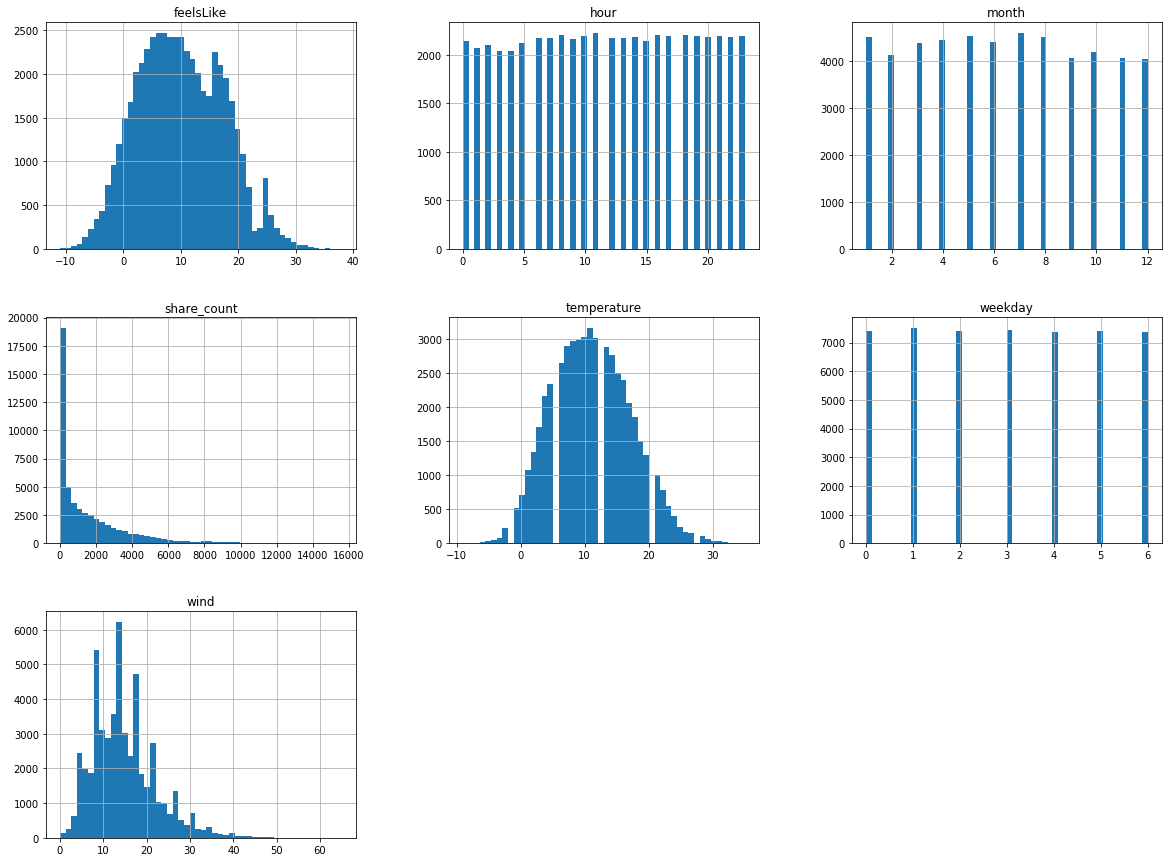

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
bike_share_df.hist(bins=50, figsize=(20,15))
plt.show()

Text(0.5, 1.0, 'Ungrouped weather codes')

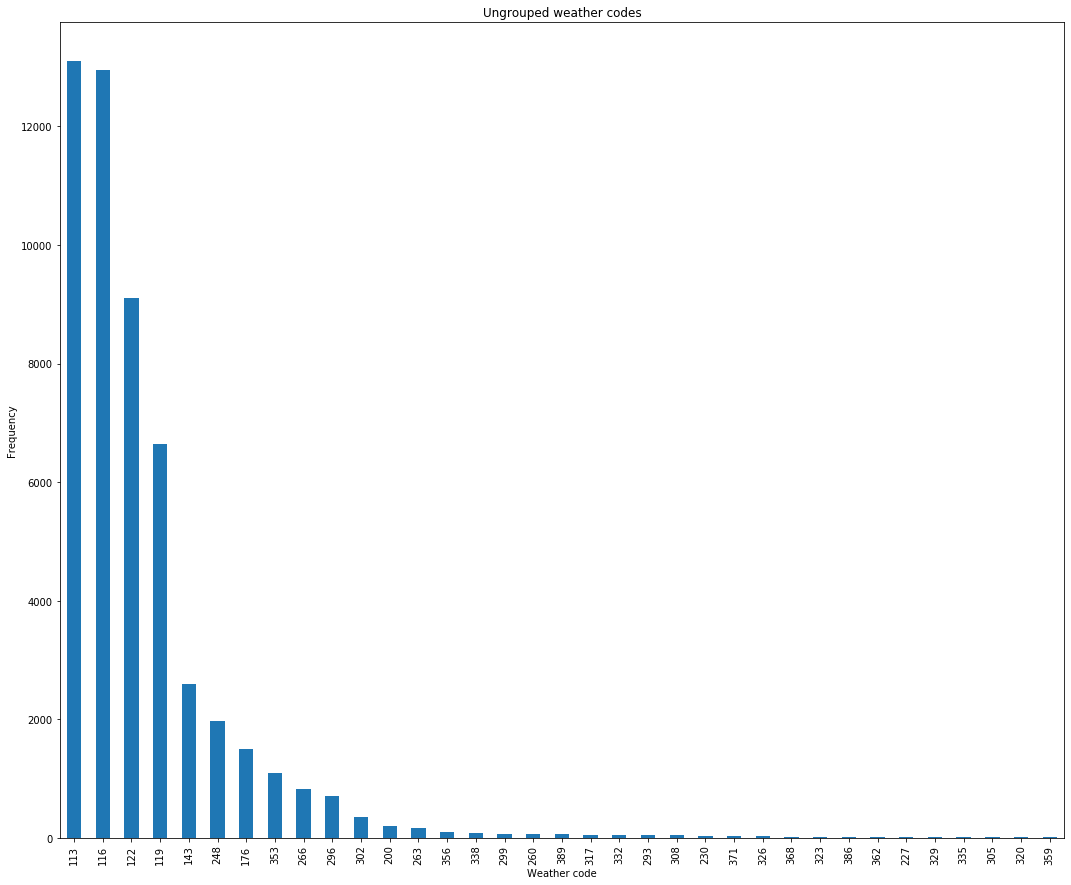

In [16]:
ax = bike_share_df['weatherCode'].value_counts().plot('bar', figsize=(18, 15))
ax.set_xlabel('Weather code')
ax.set_ylabel('Frequency')
ax.set_title('Ungrouped weather codes')

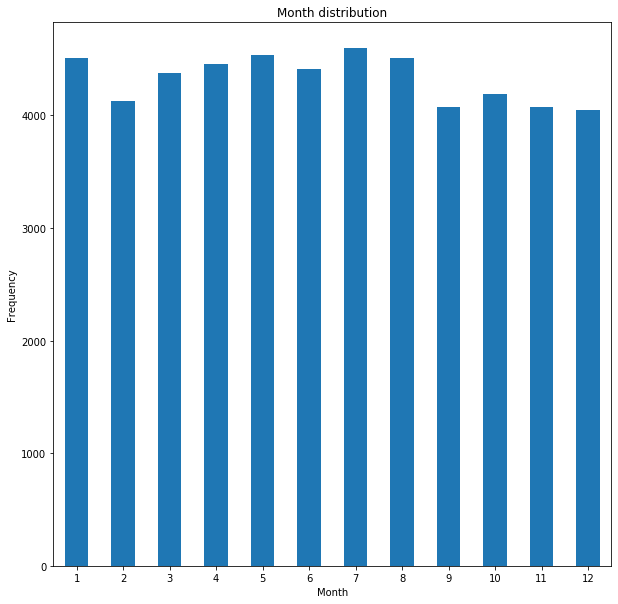

In [17]:
ax = bike_share_df['month'].value_counts(sort=False).plot('bar', figsize=(10,10))
ax.set_xlabel('Month')
ax.set_ylabel('Frequency')
ax.set_title('Month distribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

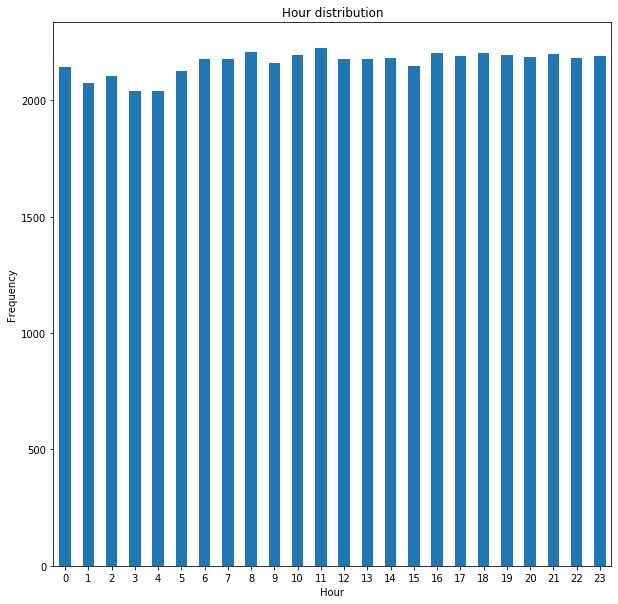

In [18]:
ax = bike_share_df['hour'].value_counts(sort=False).plot('bar', figsize=(10,10))
ax.set_xlabel('Hour')
ax.set_ylabel('Frequency')
ax.set_title('Hour distribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

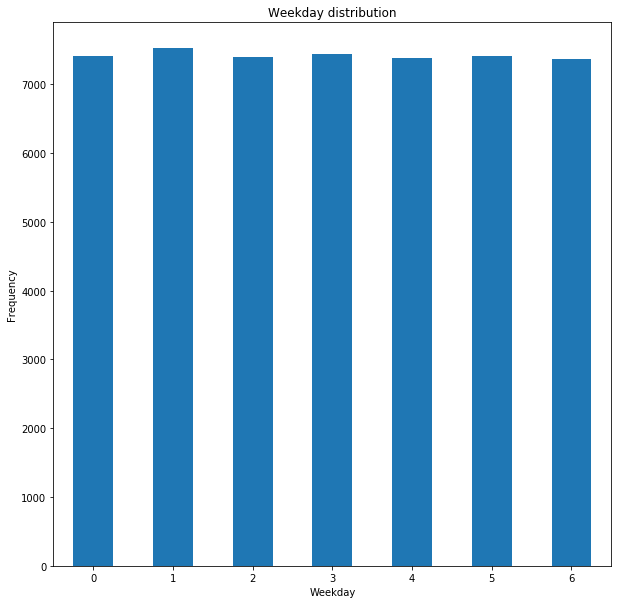

In [19]:
ax = bike_share_df['weekday'].value_counts(sort=False).plot('bar', figsize=(10,10))
ax.set_xlabel('Weekday')
ax.set_ylabel('Frequency')
ax.set_title('Weekday distribution')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

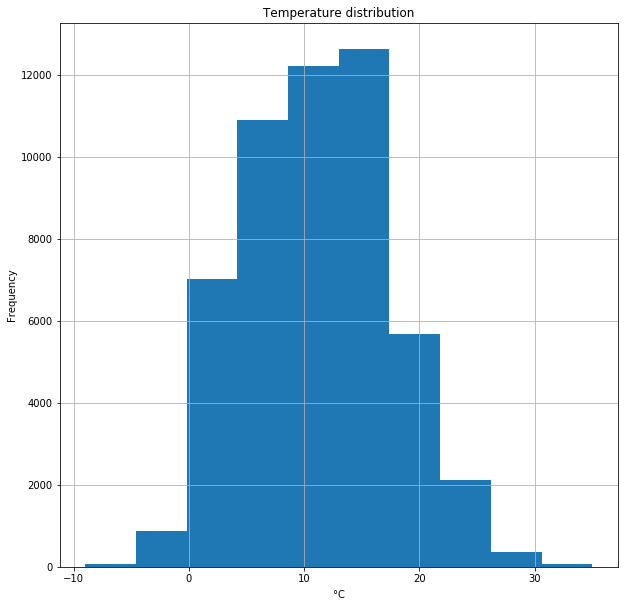

In [20]:
ax = bike_share_df['temperature'].hist(bins=10, figsize=(10,10))
ax.set_xlabel(r'$\degree$C')
ax.set_ylabel('Frequency')
_ = ax.set_title('Temperature distribution')

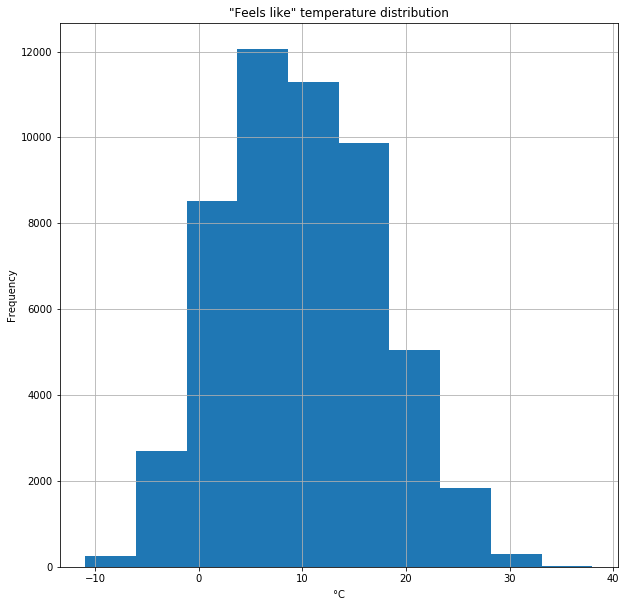

In [21]:
ax = bike_share_df['feelsLike'].hist(bins=10, figsize=(10,10))
ax.set_xlabel(r'$\degree$C')
ax.set_ylabel('Frequency')
_ = ax.set_title('"Feels like" temperature distribution')

In [22]:
bike_share_df[bike_share_df['share_count'] <= 100].shape

(12439, 11)

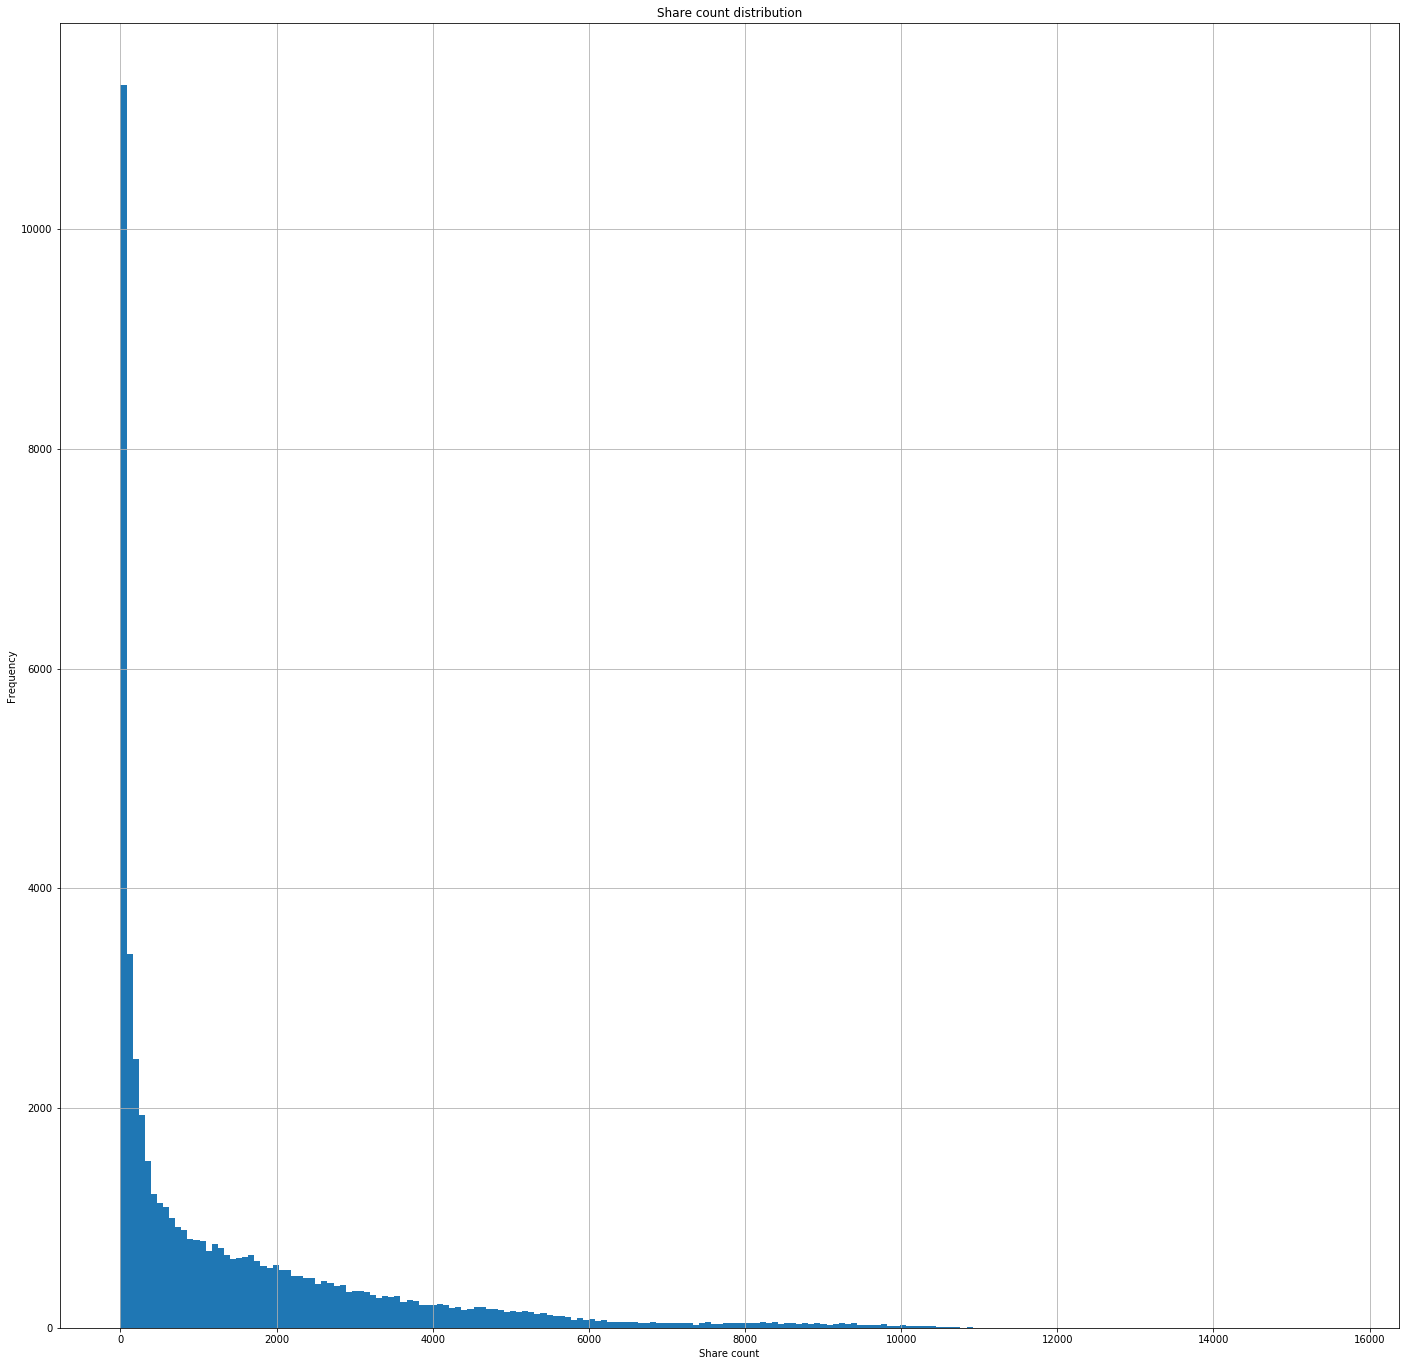

In [23]:
ax = bike_share_df['share_count'].hist(bins=200, figsize=(24,24))
ax.set_xlabel('Share count')
ax.set_ylabel('Frequency')
_ = ax.set_title('Share count distribution')

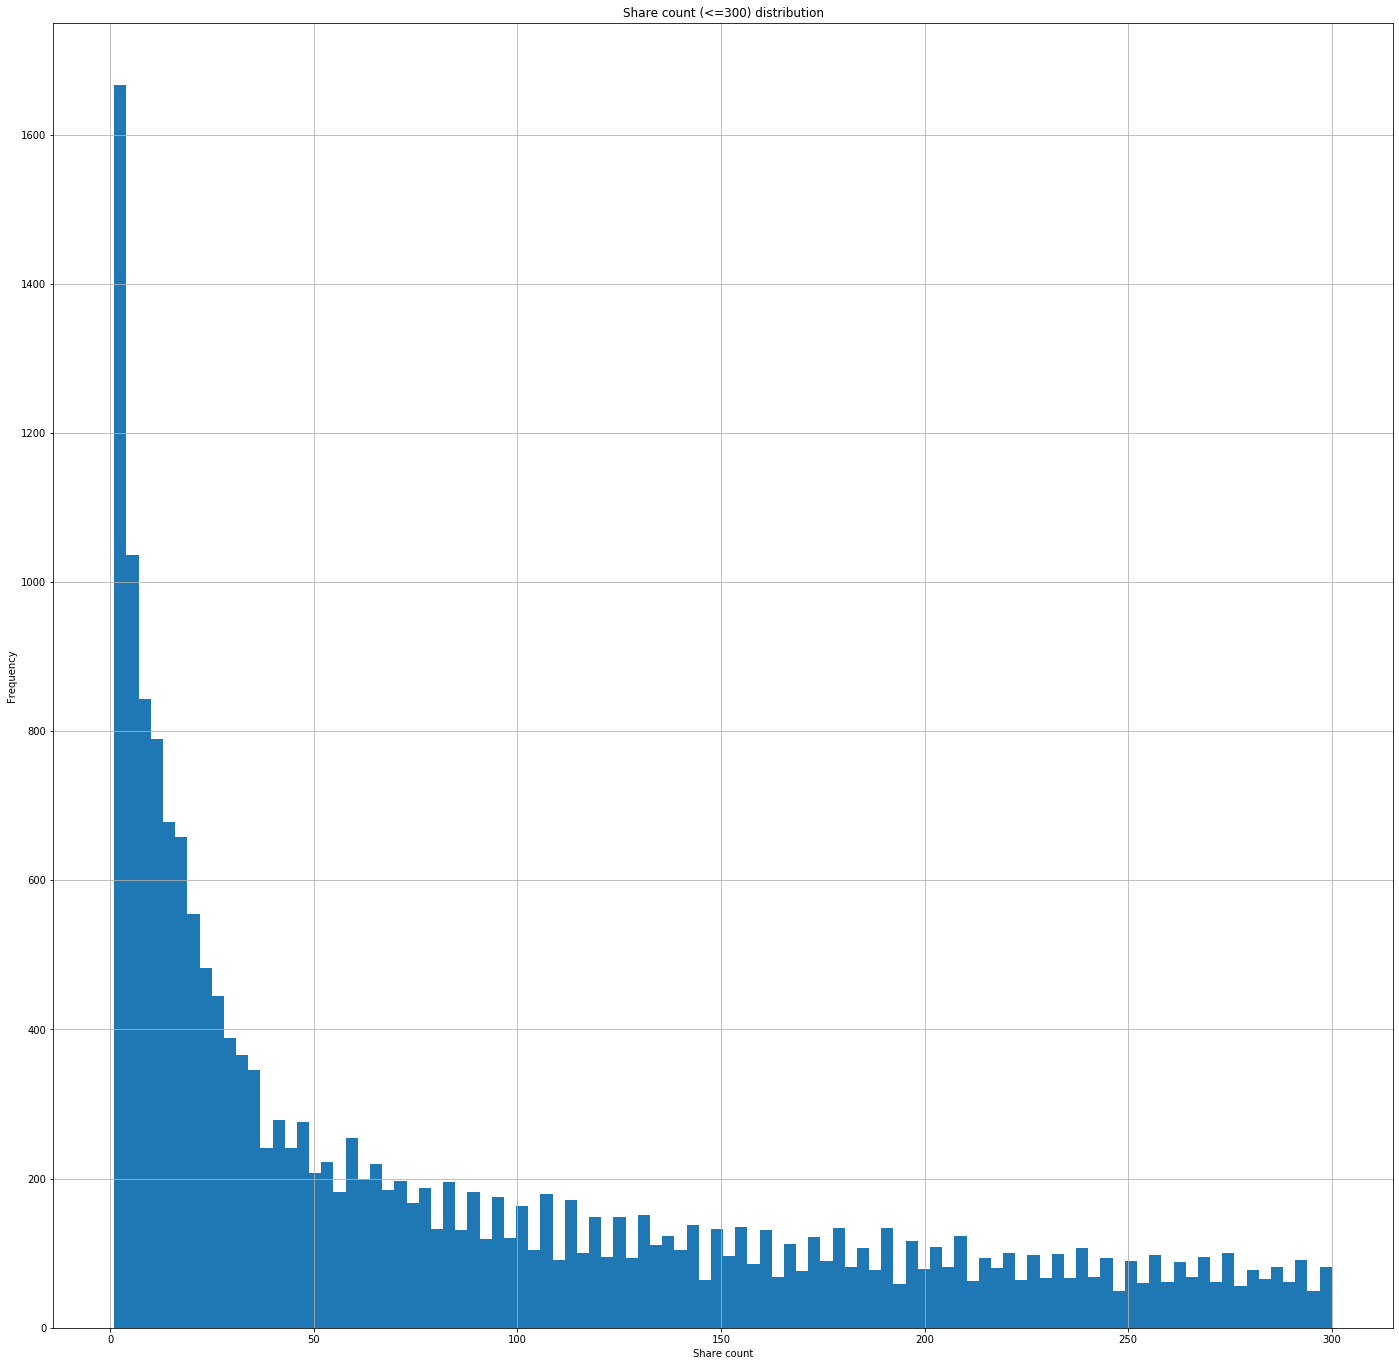

In [24]:
ax = bike_share_df[bike_share_df['share_count'] <= 300]['share_count'].hist(bins=100, figsize=(24,24))
ax.set_xlabel('Share count')
ax.set_ylabel('Frequency')
_ = ax.set_title('Share count (<=300) distribution')

In [25]:
shares_extra_attribs = group_weather_codes(bike_share_df.values)
shares_extra_attribs = pd.DataFrame(
    shares_extra_attribs,
    columns=bike_share_df.columns,
    index=bike_share_df.index)

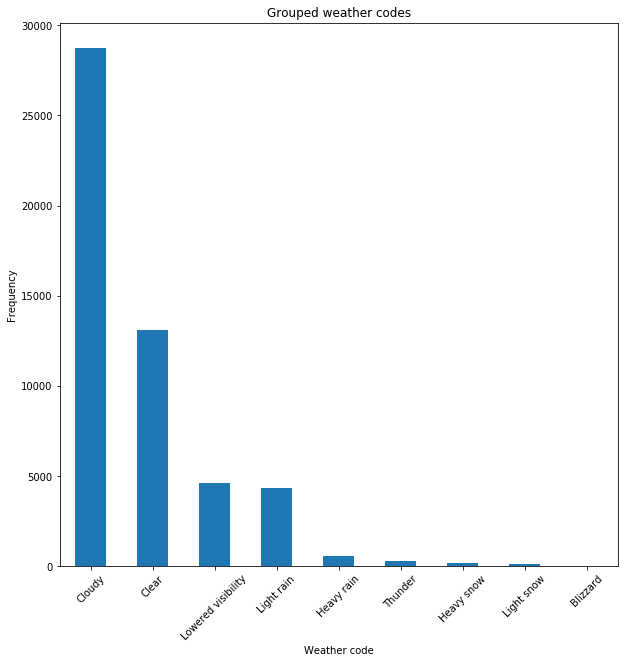

In [26]:
ax = shares_extra_attribs['weatherCode'].value_counts().plot('bar', figsize=(10,10))
ax.set_xlabel('Weather code')
ax.set_ylabel('Frequency')
ax.set_title('Grouped weather codes')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

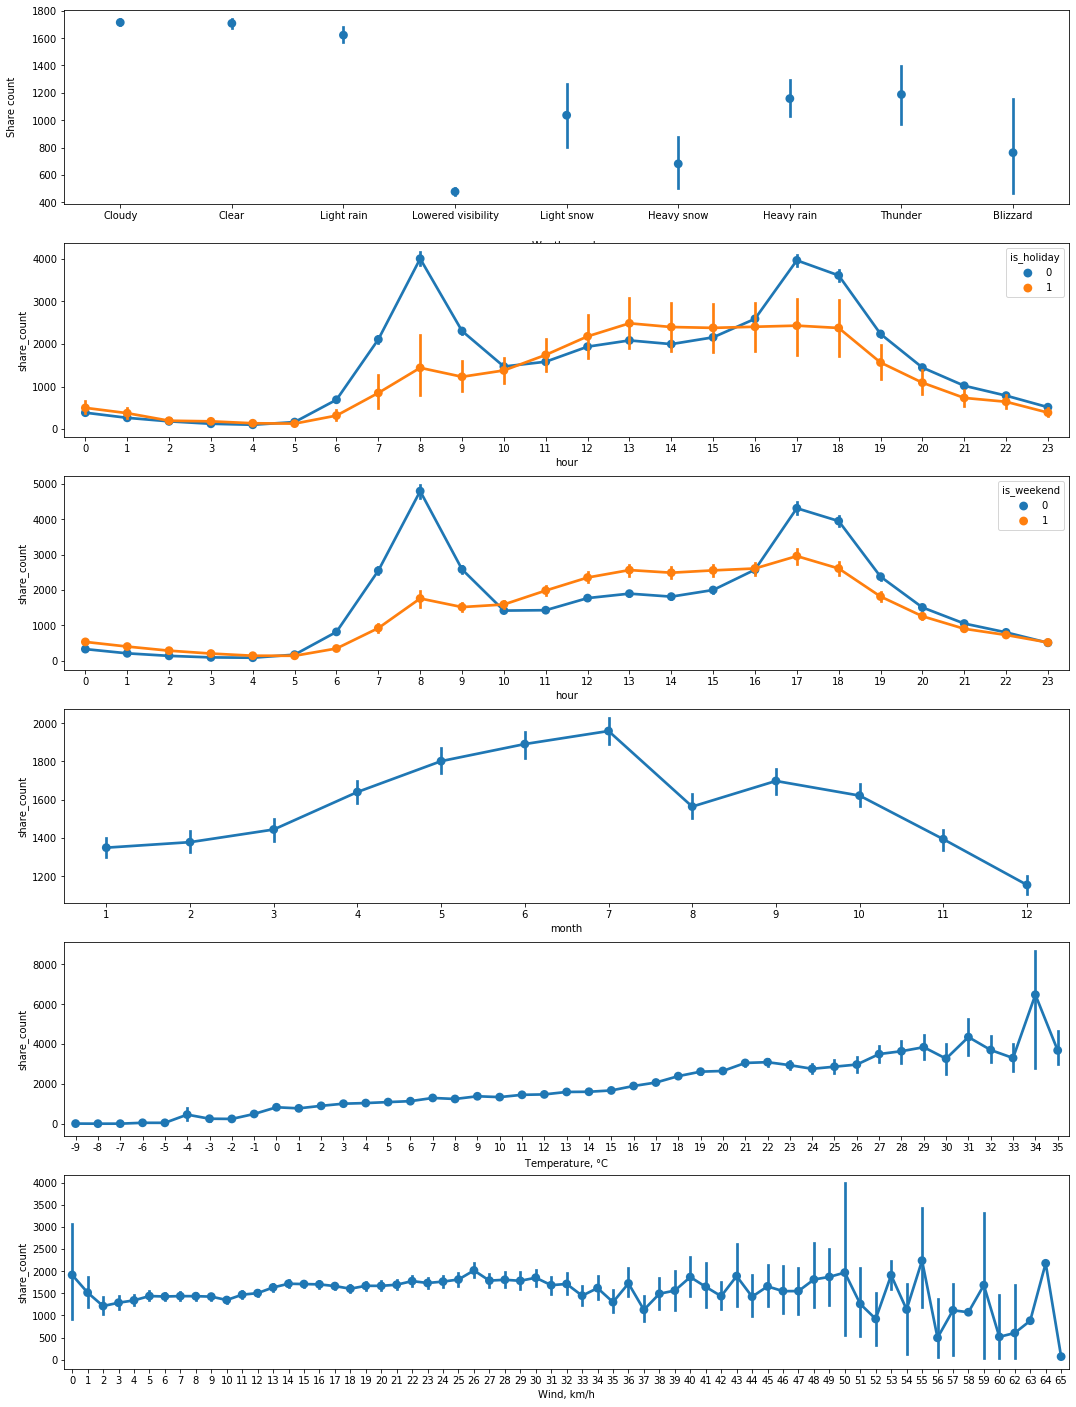

In [27]:
fig,(ax1, ax2, ax3, ax4, ax5, ax6)= plt.subplots(nrows=6)
fig.set_size_inches(fig_size)

sns.pointplot(data=shares_extra_attribs, x='weatherCode', y='share_count', ax=ax1, join=False)
sns.pointplot(data=shares_extra_attribs, x='hour', y='share_count', hue='is_holiday', ax=ax2)
sns.pointplot(data=shares_extra_attribs, x='hour', y='share_count', hue='is_weekend', ax=ax3)
sns.pointplot(data=shares_extra_attribs, x='month', y='share_count', ax=ax4)
temp_int = shares_extra_attribs.copy()
temp_int['temperature'] = temp_int['temperature'].map(int)
temp_int['wind'] = temp_int['wind'].map(int)
sns.pointplot(data=temp_int, x='temperature', y='share_count', ax=ax5)
ax5.set_xlabel(r'Temperature, $\degree$C')
sns.pointplot(data=temp_int, x='wind', y='share_count', ax=ax6)
ax6.set_xlabel('Wind, km/h')
ax1.set_xlabel('Weather code', labelpad=20)
_ = ax1.set_ylabel('Share count', labelpad=15)

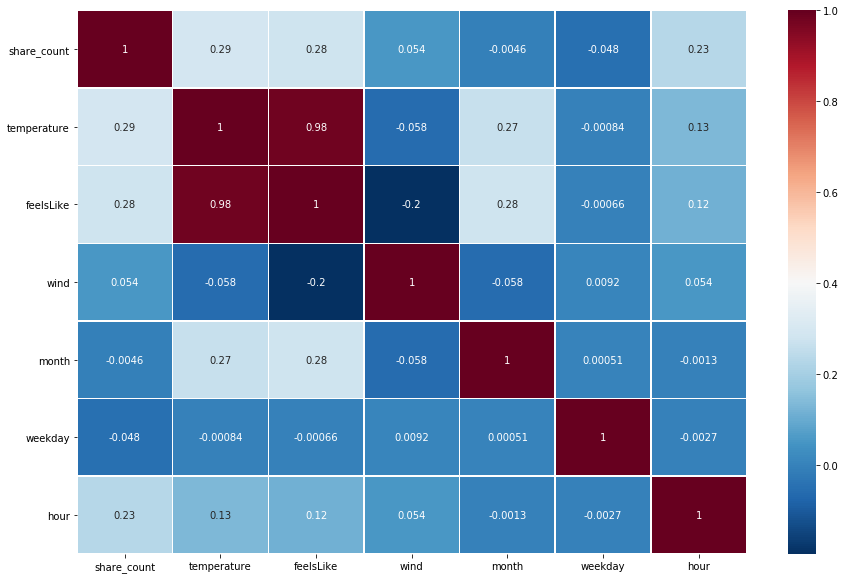

In [28]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(15,10)

pearsoncorr = bike_share_df.drop('Start Date', axis=1).corr(method='pearson')
heat_map=sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

### Dealing with cyclical data

In [29]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str,
    'share_count': int,
    'temperature': float,
    'feelsLike': float,
    'wind': float,
    'hr_sin': float,
    'hr_cos': float,
    'mnth_sin': float,
    'mnth_cos': float
}
cols = list(shares_extra_attribs.columns.drop(['hour', 'month'])) + ['hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos']
shares_extra_attribs = convert_cyclical_data(shares_extra_attribs.values)
shares_extra_attribs = pd.DataFrame(
    shares_extra_attribs,
    columns=cols).astype(types)

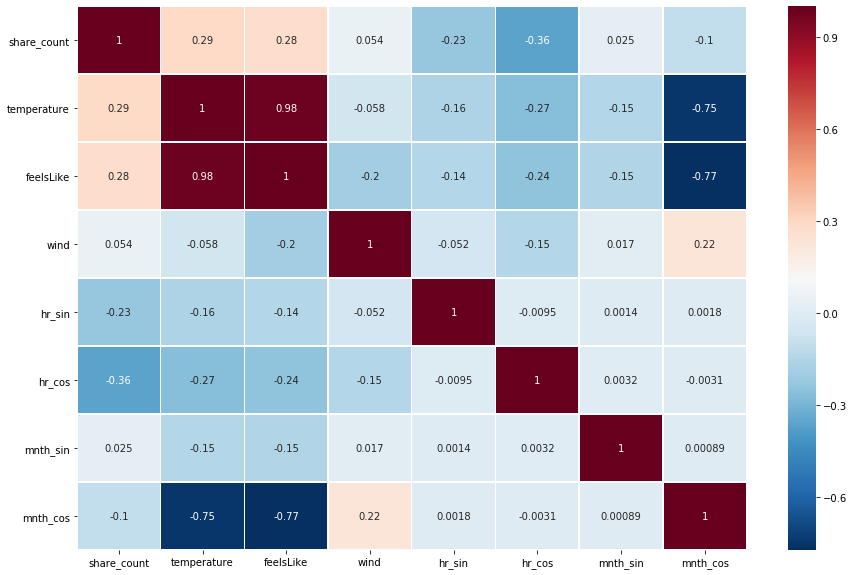

In [30]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(15,10)

pearsoncorr = shares_extra_attribs.drop('Start Date', axis=1).corr(method='pearson')
heat_map=sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

### Adding lag value

In [31]:
types = {
    **types,
    'lag_1': int,
    'lag_2': int,
    'lag_3': int
}

cols += ['lag_1', 'lag_2', 'lag_3']
shares_extra_attribs = add_lag_value(shares_extra_attribs.values, count=3)
shares_extra_attribs = pd.DataFrame(
    shares_extra_attribs,
    columns=cols).astype(types)
shares_extra_attribs = shares_extra_attribs.reset_index(drop=True)

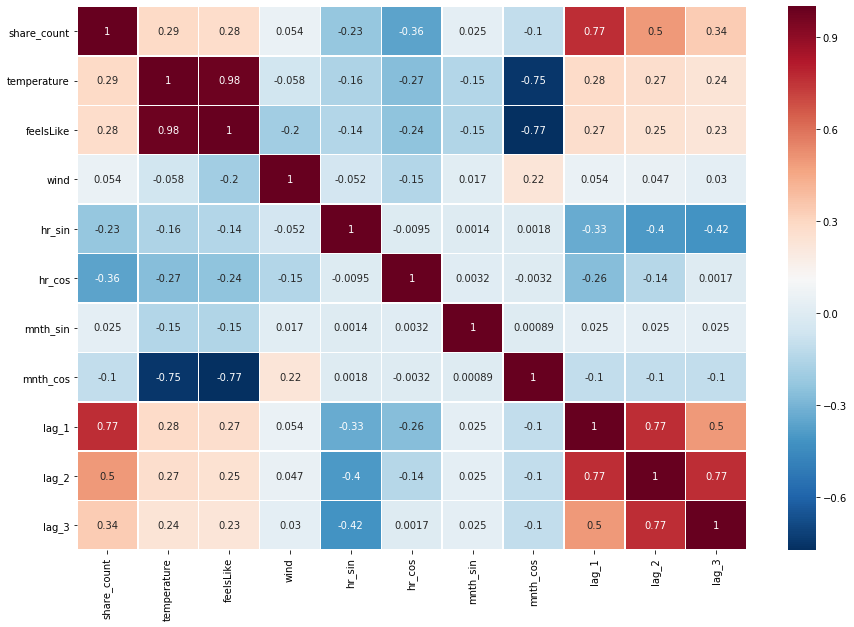

In [32]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(15,10)

pearsoncorr = shares_extra_attribs.drop('Start Date', axis=1).corr(method='pearson')
heat_map=sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

### Transform data for the model

In [33]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str,
    'share_count': int,
    'temperature': float,
    'feelsLike': float,
    'wind': float,
    'hr_sin': float,
    'hr_cos': float,
    'mnth_sin': float,
    'mnth_cos': float,
    'lag_1': int
}
def transform_data(df):
    columns = list(df.columns.drop(['hour', 'month']))+['hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos', 'lag_1', 'lag_2', 'lag_3']
    values = group_weather_codes(df.values)
    values = convert_cyclical_data(values)
    values = add_lag_value(values, count=3)
    df = pd.DataFrame(
        values,
        columns=columns
    ).astype(types)
    # one-hot encode the data
    # weather codes
    encoded_weather_codes = pd.get_dummies(df['weatherCode'], prefix='weather')
    df = df.drop(['weatherCode'], axis=1)
    df = df.join(encoded_weather_codes)
    # holiday & weekend
    holiday_enc = pd.get_dummies(df['is_holiday'], prefix='holiday')
    week_enc = pd.get_dummies(df['is_weekend'], prefix='weekend')
    df = df.join(holiday_enc).join(week_enc)
    df = df.drop(['is_holiday', 'is_weekend'], axis=1)
    # "weekday" could be dropped due to the fact that we have "is_weekend"
    df = df.drop(['weekday'], axis=1)
    return df

In [34]:
# encoded_weather_codes = pd.get_dummies(shares_extra_attribs['weatherCode'], prefix='weather')
# bike_share_df_enc = shares_extra_attribs.drop(['weatherCode'], axis=1)
# bike_share_df_enc = shares_extra_attribs.join(encoded_weather_codes)

In [35]:
# holiday_enc = pd.get_dummies(shares_extra_attribs['is_holiday'], prefix='holiday')
# week_enc = pd.get_dummies(shares_extra_attribs['is_weekend'], prefix='weekend')
# bike_share_df_enc = bike_share_df_enc.join(holiday_enc).join(week_enc)
# bike_share_df_enc = bike_share_df_enc.drop(['is_holiday', 'is_weekend'], axis=1)
# # "weekday" could be dropped due to the fact that we have "is_weekend"
# bike_share_df_enc = bike_share_df_enc.drop(['weekday'], axis=1)

In [36]:
bike_share_df_enc = transform_data(bike_share_df)
bike_share_df_enc.head()

,Start Date,share_count,temperature,feelsLike,wind,hr_sin,hr_cos,mnth_sin,mnth_cos,lag_1,...,weather_Heavy rain,weather_Heavy snow,weather_Light rain,weather_Light snow,weather_Lowered visibility,weather_Thunder,holiday_0,holiday_1,weekend_0,weekend_1
0,2012-01-02 04:00:00,12,5.0,2.0,18.0,0.866025,5.000000e-01,0.0,1.0,9,...,0,0,0,0,0,0,0,1,1,0
1,2012-01-02 05:00:00,30,4.0,1.0,18.0,0.965926,2.588190e-01,0.0,1.0,12,...,0,0,0,0,0,0,0,1,1,0
2,2012-01-02 06:00:00,210,4.0,0.0,19.0,1.000000,6.123234e-17,0.0,1.0,30,...,0,0,0,0,0,0,0,1,1,0
3,2012-01-02 07:00:00,737,4.0,0.0,19.0,0.965926,-2.588190e-01,0.0,1.0,210,...,0,0,0,0,0,0,0,1,1,0
4,2012-01-02 08:00:00,1515,4.0,0.0,19.0,0.866025,-5.000000e-01,0.0,1.0,737,...,0,0,0,0,0,0,0,1,1,0


In [37]:
from sklearn.utils import shuffle
test_set = transform_data(test_set.sort_values('Start Date'))
test_set = shuffle(test_set, random_state=random_state).reset_index(drop=True)

### Training the model

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor

In [39]:
# shuffle the dataframe
bike_share_df = shuffle(bike_share_df, random_state=random_state).reset_index(drop=True)
bike_share_df.head(5)

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,2016-07-19 05:00:00,378,15.0,15.0,12.0,119,7,1,5,0,0
1,2013-12-04 07:00:00,26,6.0,3.0,16.0,116,12,2,7,0,0
2,2013-12-18 19:00:00,744,8.0,4.0,32.0,122,12,2,19,0,0
3,2017-04-24 21:00:00,1300,6.0,2.0,22.0,113,4,0,21,0,0
4,2015-03-30 21:00:00,920,12.0,8.0,48.0,122,3,0,21,0,0


In [40]:
train_set = bike_share_df_enc.drop('Start Date', axis=1)
test_set = test_set.drop('Start Date', axis=1)

X_train = train_set.drop('share_count', axis=1).to_numpy()
Y_train = train_set['share_count'].to_numpy()

X_test = test_set.drop('share_count', axis=1).to_numpy()
Y_test = test_set['share_count'].to_numpy()

In [41]:
classifiers = [
#     ('Decision Tree', DecisionTreeClassifier()),
#     ('Random Forest', RandomForestClassifier(n_estimators=100)),
#     ('NN (50, 50, 16)', MLPClassifier(hidden_layer_sizes=(16, 16, 16), verbose=True, learning_rate='adaptive', activation='tanh', learning_rate_init=0.01))
    ('Lasso', Lasso(random_state=random_state)),
    ('ElasticNet', ElasticNet(random_state=random_state)),
    ('Ridge', Ridge(random_state=random_state)),
#     ('SVR linear', SVR(kernel='linear', verbose=True)),
#     ('SVR rbf', SVR(kernel='rbf', verbose=True)),
#     ('SGDRegressor', SGDRegressor()),
    ('GradientBoostRegressor', GradientBoostingRegressor()),
    ('GradientBoostRegressor(ls)', GradientBoostingRegressor(max_features=21, random_state=random_state, max_depth=8)),
    ('Optimized GradientBoostRegressor(huber)', GradientBoostingRegressor(loss='huber', max_features=21, n_estimators=160, random_state=random_state, max_depth=8))
]

In [42]:
import time
def learn(classifiers, X_train, Y_train, X_test, Y_test):
    for name, clf in classifiers:
        print(f'** {name}')
        t0 = time.time()
        clf.fit(X_train, Y_train)
        t1 = time.time()
        score_train = clf.score(X_train[:10000], Y_train[:10000])
        t2 = time.time()
        score_test = clf.score(X_test, Y_test)
        t3 = time.time()
        print(f'\tTraining time {t1 - t0:3.3f}')
        print(f'\tPrediction time (train) {t2 - t1:3.3f}')
        print(f'\tPrediction time (test) {t3 - t2:3.3f}')
        print(f'\tScore train: {score_train:.3f}\tScore Test: {score_test:.3f}')

In [43]:
# learn(classifiers, X_train, Y_train, X_test, Y_test)

In [44]:
# # Search through param_grid parameters, find the best set of parameters for GBR (Gradient Boosting Regressor)
# param_grid = [
#     {'max_features': [21], 'max_depth': [3, 10, 20, 50, 100]}
#   ]

# clf = GradientBoostingRegressor(random_state=random_state)

# grid_search = GridSearchCV(clf, param_grid, cv=5,
#                            scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train, Y_train)

# # Run GBR with best set of parameters
# clf = GradientBoostingRegressor(random_state=random_state,
#                                 **grid_search.best_params_,
#                                 n_estimators=2000)

# clf.fit(X_train, Y_train)
# results = clf.predict(X_test)
# score = clf.score(X_test, Y_test)
# print("TEST SCORE: " + str(score))

In [45]:
optimized_clf = GradientBoostingRegressor(loss='huber', max_features=23, n_estimators=160, random_state=random_state, max_depth=8)
optimized_clf.fit(X_train, Y_train)
results = optimized_clf.predict(X_test)

score = optimized_clf.score(X_test, Y_test)
print("Test score: " + str(score))

Test score: 0.3586125559820304


In [46]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(Y_test, results)
lin_rmse = np.sqrt(lin_mse)

In [47]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(Y_test, results)

In [48]:
# count negative
(results < 0).shape

(12978,)

In [49]:
from sklearn.metrics import explained_variance_score
y_true = Y_test
y_pred = results
var_score = explained_variance_score(y_true, y_pred)  

In [50]:
print("Mean squared error: " + str(lin_rmse))
print("Mean squared error: " + str(lin_mae))
print("Variance score: " + str(var_score))

Mean squared error: 1578.6295549657796
Mean squared error: 830.4195230632591
Variance score: 0.37034155105975575
